In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [3]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042464 entries, 0 to 2042463
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.2 MB


# reduce to 1 million events

In [5]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [6]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,15272,0.23,15.272
1,15272,0.23,15.272
2,15308,0.23,15.308
3,15306,0.23,15.306
4,15218,0.24,15.218
...,...,...,...
999995,28664,0.12,28.664
999996,28236,0.13,28.236
999997,28706,0.12,28.706
999998,29500,0.12,29.500


In [7]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [8]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [9]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26050955102000

### Calcul de la date de base = now - cumul_interval

In [10]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 5, 24, 20, 19, 53, 921410)

In [11]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [12]:
conso_data.iloc[0]


Interval     15272.000000
kWh              0.230000
sec             15.272000
Wh             235.725511
cumul(ms)    15272.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [13]:
base

datetime.datetime(2024, 5, 24, 20, 19, 53, 921410)

## créer les dates

In [14]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-05-24 20:20:09.193410
1        2024-05-24 20:20:24.465410
2        2024-05-24 20:20:39.773410
3        2024-05-24 20:20:55.079410
4        2024-05-24 20:21:10.297410
                    ...            
999995   2025-03-22 08:40:33.192410
999996   2025-03-22 08:41:01.428410
999997   2025-03-22 08:41:30.134410
999998   2025-03-22 08:41:59.634410
999999   2025-03-22 08:42:29.023410
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [15]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,15272,0.23,15.272,235.725511,15272,2024-05-24 20:20:09.193410,24/05/24
1,15272,0.23,15.272,235.725511,30544,2024-05-24 20:20:24.465410,24/05/24
2,15308,0.23,15.308,235.171152,45852,2024-05-24 20:20:39.773410,24/05/24
3,15306,0.23,15.306,235.201882,61158,2024-05-24 20:20:55.079410,24/05/24
4,15218,0.24,15.218,236.561966,76376,2024-05-24 20:21:10.297410,24/05/24
...,...,...,...,...,...,...,...
999995,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25
999996,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25
999997,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25
999998,29500,0.12,29.500,122.033898,26050925713,2025-03-22 08:41:59.634410,22/03/25


### save conso_data with dates

In [16]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [17]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('22/03/25', 22, 3, 2025)

In [18]:
here = now.strftime('%H:%M:%S')
here

'08:42:48'

In [19]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [20]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 998523 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1477 non-null   int64         
 1   kWh        1477 non-null   float64       
 2   sec        1477 non-null   float64       
 3   Wh         1477 non-null   float64       
 4   cumul(ms)  1477 non-null   int64         
 5   dates      1477 non-null   datetime64[ns]
 6   days       1477 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 92.3+ KB


In [21]:
end = time.time()
print(end - start)

22.25147294998169


### grouped by days

In [22]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [23]:
data = list(df_grp['kWh'])
print(data)

[0.943, 3.671, 3.65, 3.773, 3.559, 3.093, 3.273, 4.143, 3.603, 4.265, 3.56, 3.315, 3.484, 3.181, 2.934, 3.413, 3.173, 3.307, 3.731, 3.361, 3.342, 3.095, 2.959, 3.695, 3.216, 3.125, 3.256, 3.356, 2.983, 3.037, 3.49, 3.69, 3.438, 3.045, 2.883, 2.079, 2.093, 2.084, 2.081, 2.086, 2.087, 2.076, 2.075, 2.117, 3.663, 3.13, 3.468, 3.792, 3.609, 3.793, 3.561, 3.658, 3.587, 3.485, 3.388, 3.283, 3.471, 3.289, 3.758, 3.673, 3.565, 3.597, 3.424, 3.229, 3.202, 2.859, 3.028, 3.69, 3.786, 3.761, 3.011, 3.359, 3.36, 3.512, 3.659, 3.697, 3.544, 3.703, 3.868, 3.802, 4.366, 4.216, 3.84, 3.971, 3.982, 3.827, 3.856, 3.708, 3.257, 3.97, 3.957, 4.41, 3.743, 4.184, 3.736, 3.967, 3.826, 3.897, 3.735, 3.59, 3.515, 3.706, 3.534, 4.064, 3.766, 3.39, 3.484, 3.296, 2.326, 1.796, 1.793, 1.792, 1.796, 2.529, 1.809, 1.788, 1.79, 1.792, 1.822, 1.822, 1.813, 1.817, 1.819, 1.818, 1.817, 1.81, 1.785, 1.787, 1.784, 1.787, 1.783, 1.796, 1.789, 1.788, 1.785, 1.796, 1.804, 1.794, 1.806, 1.794, 1.784, 1.79, 1.786, 1.79, 1.797, 

In [24]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [25]:
end = time.time()
print(end - start)

22.644652366638184


### plot function by day
#### show('dd/mm/yy')

In [26]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


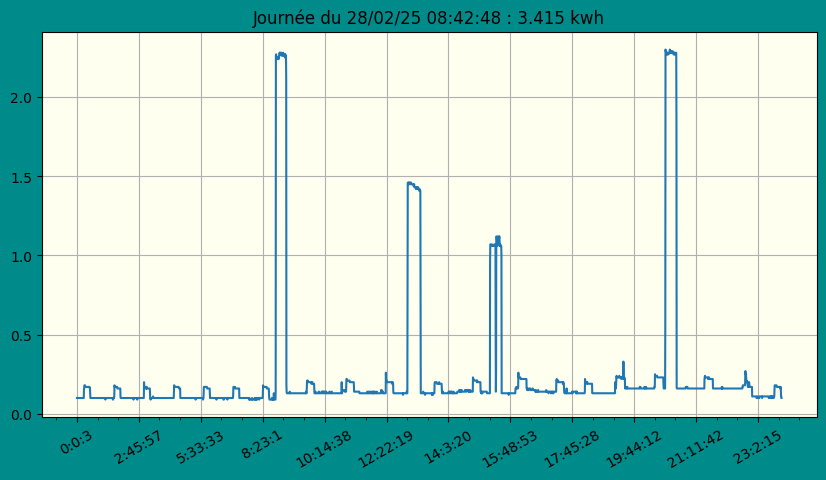

In [27]:
show('28/02/25')

In [28]:
end = time.time()
print(end - start)

24.62416410446167


### 1 kWh window in data of one day
#### df = conso_day

In [29]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998523,33482,0.11,33.482,107.520459,26019617624,2025-03-22 00:00:11.545410,22/03/25
998524,31490,0.11,31.490,114.322007,26019649114,2025-03-22 00:00:43.035410,22/03/25
998525,31914,0.11,31.914,112.803158,26019681028,2025-03-22 00:01:14.949410,22/03/25
998526,33283,0.11,33.283,108.163327,26019714311,2025-03-22 00:01:48.232410,22/03/25
998527,33103,0.11,33.103,108.751473,26019747414,2025-03-22 00:02:21.335410,22/03/25
...,...,...,...,...,...,...,...
999995,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25
999996,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25
999997,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25
999998,29500,0.12,29.500,122.033898,26050925713,2025-03-22 08:41:59.634410,22/03/25


In [30]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [31]:
df = conso_day
len(df)

1477

In [32]:
period()  # first kWh

2025-03-22 00:00:11.545410	2025-03-22 06:39:00.250410	6h 38m 48s 	1000


In [33]:
period(p=2) # second period

2025-03-22 06:39:00.250410	2025-03-22 08:42:29.023410	2h 3m 28s 	477


In [34]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.290012
dtype: float64

In [35]:
end = time.time()
print(end - start)

25.050445556640625


## mean for data grouped by days

In [36]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [37]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.477)

# conso by date


In [38]:
# select day
day = today

#day = '16/08/24'
day

'22/03/25'

In [39]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998523,33482,0.11,33.482,107.520459,26019617624,2025-03-22 00:00:11.545410,22/03/25
998524,31490,0.11,31.490,114.322007,26019649114,2025-03-22 00:00:43.035410,22/03/25
998525,31914,0.11,31.914,112.803158,26019681028,2025-03-22 00:01:14.949410,22/03/25
998526,33283,0.11,33.283,108.163327,26019714311,2025-03-22 00:01:48.232410,22/03/25
998527,33103,0.11,33.103,108.751473,26019747414,2025-03-22 00:02:21.335410,22/03/25
...,...,...,...,...,...,...,...
999995,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25
999996,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25
999997,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25
999998,29500,0.12,29.500,122.033898,26050925713,2025-03-22 08:41:59.634410,22/03/25


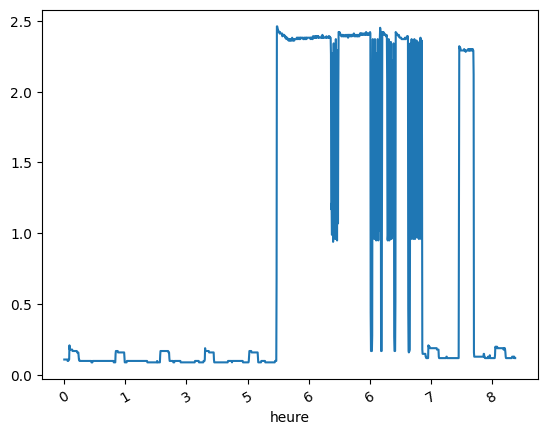

In [40]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [41]:
end = time.time()
print(end - start)

25.94900107383728


### grouped by 'heure'

In [42]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 998523 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1477 non-null   int64         
 1   kWh        1477 non-null   float64       
 2   sec        1477 non-null   float64       
 3   Wh         1477 non-null   float64       
 4   cumul(ms)  1477 non-null   int64         
 5   dates      1477 non-null   datetime64[ns]
 6   days       1477 non-null   object        
 7   heure      1477 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 103.9+ KB


In [43]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,33482,0.11,33.482,107.520459,26019617624,2025-03-22 00:00:11.545410,22/03/25
0,31490,0.11,31.490,114.322007,26019649114,2025-03-22 00:00:43.035410,22/03/25
0,31914,0.11,31.914,112.803158,26019681028,2025-03-22 00:01:14.949410,22/03/25
0,33283,0.11,33.283,108.163327,26019714311,2025-03-22 00:01:48.232410,22/03/25
0,33103,0.11,33.103,108.751473,26019747414,2025-03-22 00:02:21.335410,22/03/25
...,...,...,...,...,...,...,...
8,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25
8,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25
8,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25


In [44]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [45]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    114
1    109
2    102
3    104
4    108
5    108
6    550
7    182
8    100
Name: kWh, dtype: int64

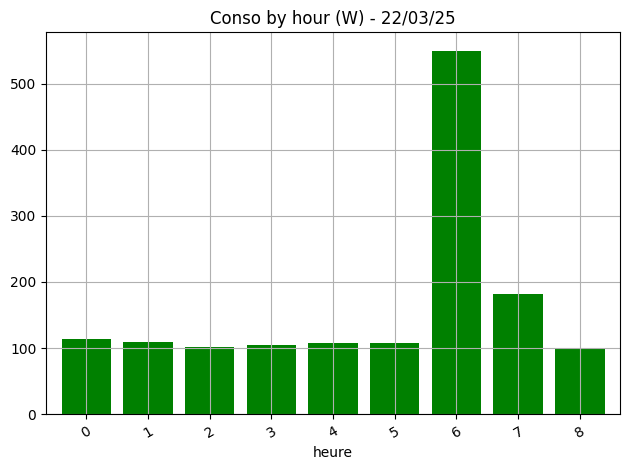

In [46]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [47]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 24/05/24 to 22/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [48]:
# give the periods of 1 kwh in a day
period()

2025-03-22 00:00:11.545410	2025-03-22 06:39:00.250410	6h 38m 48s 	1000


In [49]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-22 00:00:11.545410'),
 Timestamp('2025-03-22 06:39:01.745410'))

In [50]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [51]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [52]:
df_grp.head()


,kWh
days,
24/05/24,0.943
25/05/24,3.671
26/05/24,3.650
27/05/24,3.773
28/05/24,3.559


In [53]:
df_grp.tail()


,kWh
days,
18/03/25,3.394
19/03/25,3.966
20/03/25,3.333
21/03/25,3.126
22/03/25,1.477


In [54]:
end = time.time()
print(end - start)

27.150952339172363


# plot les 100 derniers jours


In [55]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.65629
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

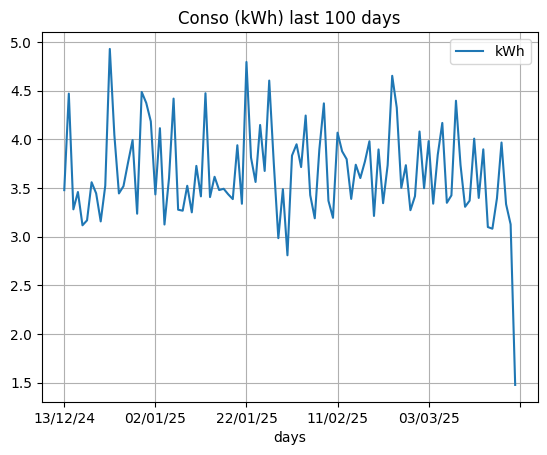

In [56]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [57]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.477
max,4.927


In [58]:
end = time.time()
print(end - start)

27.819836616516113


Text(0.5, 1.0, 'Last month conso by day')

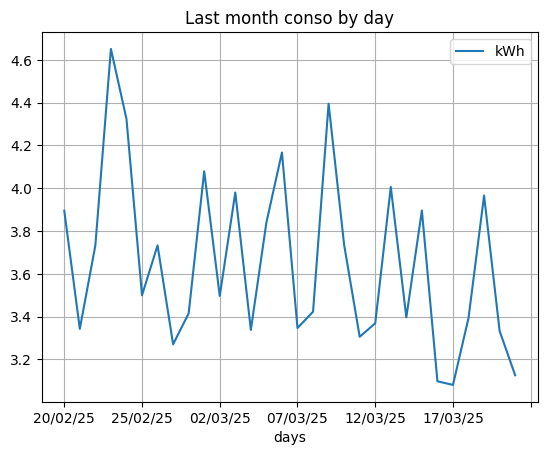

In [59]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [60]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.651
Min : 17/03/25 3.081


In [61]:

tranches = len(df)//1000
tranches+1


2

In [62]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-22 00:00:11.545410	2025-03-22 06:39:00.250410	6h 38m 48s 	1000
2025-03-22 06:39:00.250410	2025-03-22 08:42:29.023410	2h 3m 28s 	477


('08:42:48', 1.477, 1477)

In [63]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 998523 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1477 non-null   int64         
 1   kWh        1477 non-null   float64       
 2   sec        1477 non-null   float64       
 3   Wh         1477 non-null   float64       
 4   cumul(ms)  1477 non-null   int64         
 5   dates      1477 non-null   datetime64[ns]
 6   days       1477 non-null   object        
 7   heure      1477 non-null   object        
 8   hours      1477 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 115.4+ KB


In [64]:
conso_hours['heure'], conso_hours['hours']

(998523    0
 998524    0
 998525    0
 998526    0
 998527    0
          ..
 999995    8
 999996    8
 999997    8
 999998    8
 999999    8
 Name: heure, Length: 1477, dtype: object,
 998523    00
 998524    00
 998525    00
 998526    00
 998527    00
           ..
 999995    08
 999996    08
 999997    08
 999998    08
 999999    08
 Name: hours, Length: 1477, dtype: object)

In [65]:
end = time.time()
print(end - start)

28.62129497528076


# select number of days to display


In [66]:
span = 30
#df_grp.tail(span)

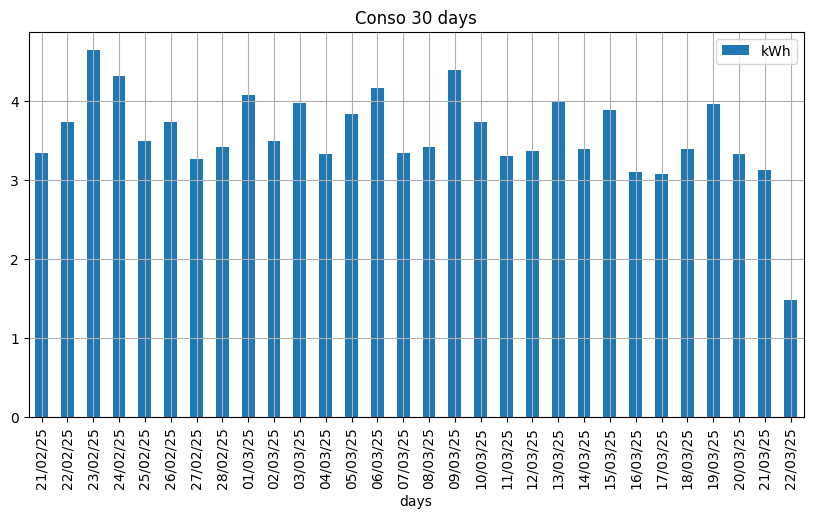

In [67]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


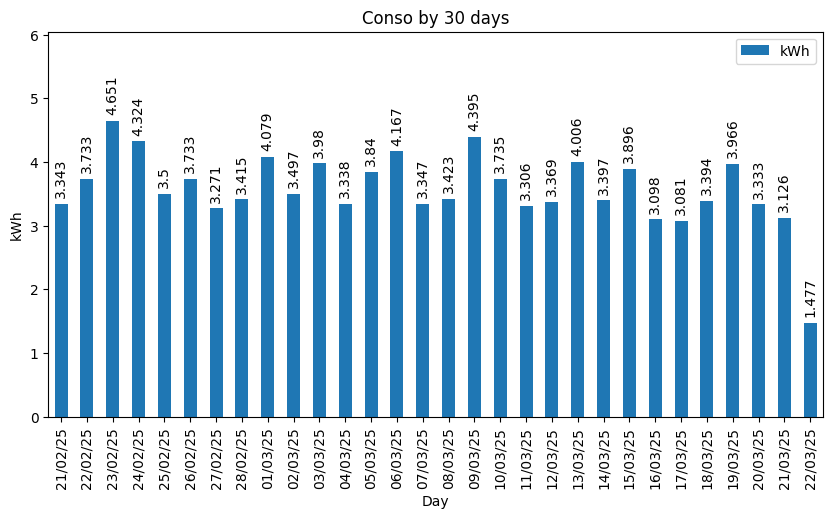

In [68]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [69]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
21/02/25    3.343
22/02/25    3.733
23/02/25    4.651
24/02/25    4.324
25/02/25    3.500
26/02/25    3.733
27/02/25    3.271
28/02/25    3.415
01/03/25    4.079
02/03/25    3.497
03/03/25    3.980
04/03/25    3.338
05/03/25    3.840
06/03/25    4.167
07/03/25    3.347
08/03/25    3.423
09/03/25    4.395
10/03/25    3.735
11/03/25    3.306
12/03/25    3.369
13/03/25    4.006
14/03/25    3.397
15/03/25    3.896
16/03/25    3.098
17/03/25    3.081
18/03/25    3.394
19/03/25    3.966
20/03/25    3.333
21/03/25    3.126
22/03/25    1.477
Name: kWh, dtype: float64

In [70]:
x_labels=df_grp.tail(span).index
x_labels

Index(['21/02/25', '22/02/25', '23/02/25', '24/02/25', '25/02/25', '26/02/25',
       '27/02/25', '28/02/25', '01/03/25', '02/03/25', '03/03/25', '04/03/25',
       '05/03/25', '06/03/25', '07/03/25', '08/03/25', '09/03/25', '10/03/25',
       '11/03/25', '12/03/25', '13/03/25', '14/03/25', '15/03/25', '16/03/25',
       '17/03/25', '18/03/25', '19/03/25', '20/03/25', '21/03/25', '22/03/25'],
      dtype='object', name='days')

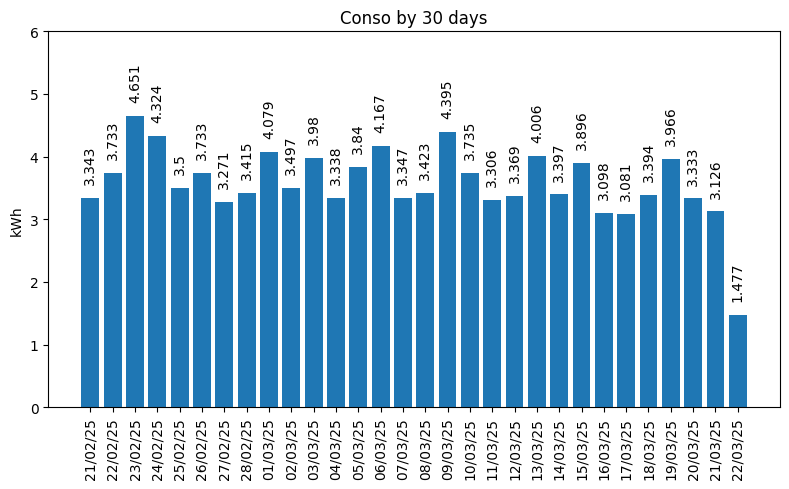

In [71]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [72]:
end = time.time()
print(end - start)

33.31514573097229


In [73]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

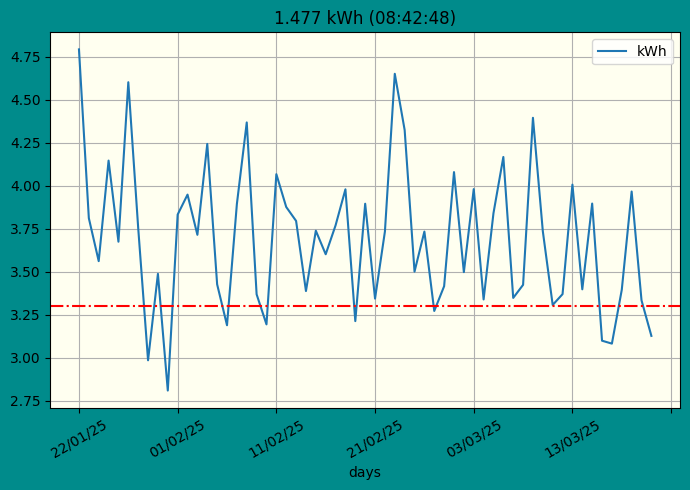

In [74]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

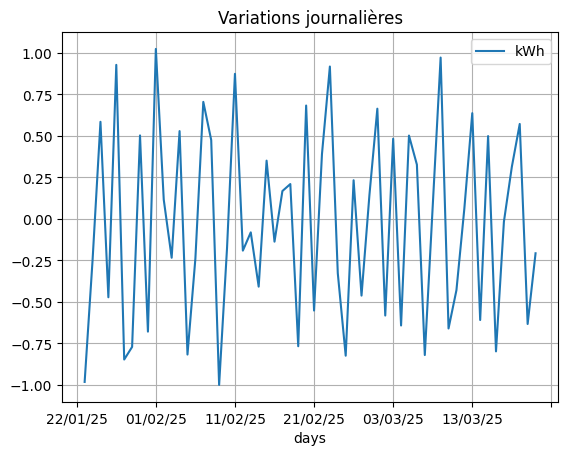

In [75]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [76]:
end = time.time()
print(end - start)

34.89982533454895


# Data from 21/08/23

In [77]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,15272,0.23,15.272,235.725511,15272,2024-05-24 20:20:09.193410,24/05/24,20,2024-05,24
1,15272,0.23,15.272,235.725511,30544,2024-05-24 20:20:24.465410,24/05/24,20,2024-05,24
2,15308,0.23,15.308,235.171152,45852,2024-05-24 20:20:39.773410,24/05/24,20,2024-05,24
3,15306,0.23,15.306,235.201882,61158,2024-05-24 20:20:55.079410,24/05/24,20,2024-05,24
4,15218,0.24,15.218,236.561966,76376,2024-05-24 20:21:10.297410,24/05/24,20,2024-05,24
...,...,...,...,...,...,...,...,...,...,...
999995,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25,08,2025-03,22
999996,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25,08,2025-03,22
999997,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25,08,2025-03,22
999998,29500,0.12,29.500,122.033898,26050925713,2025-03-22 08:41:59.634410,22/03/25,08,2025-03,22


In [78]:
end = time.time()
print(end - start)

91.03673577308655


In [79]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

# define month to show

In [80]:
month=conso_grouped_by_month.get_group('2025-02')

In [81]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

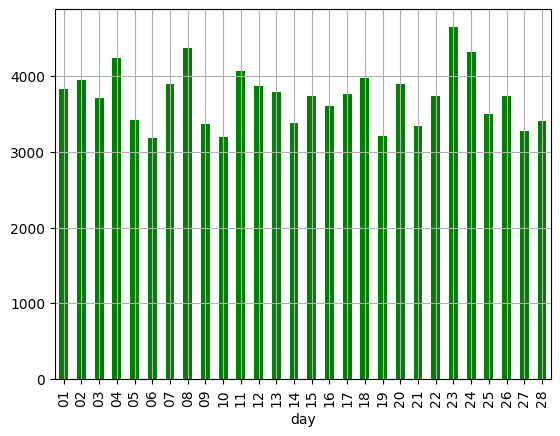

In [82]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

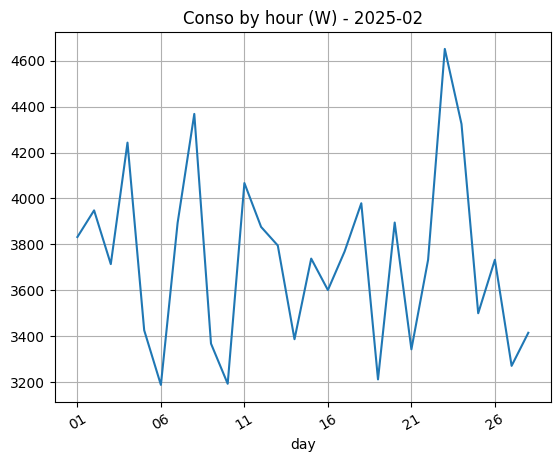

In [83]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [84]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [85]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3832,3832,3832
02,3948,3948,3948
03,3714,3714,3714
04,4243,4243,4243
05,3426,3426,3426
06,3188,3188,3188
07,3893,3893,3893
08,4368,4368,4368
09,3368,3368,3368


In [86]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [87]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [88]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-05,26105,26105,26105
2024-06,96193,96193,96193
2024-07,99510,99510,99510
2024-08,117314,117314,117314
2024-09,69647,69647,69647
2024-10,73693,73693,73693
2024-11,108460,108460,108460
2024-12,113868,113868,113868
2025-01,113498,113498,113498


In [89]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [90]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [91]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
24/05/24,943
25/05/24,3671
26/05/24,3650
27/05/24,3773
28/05/24,3559
...,...
18/03/25,3394
19/03/25,3966
20/03/25,3333


In [92]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,15272,0.23,15.272,235.725511,15272,2024-05-24 20:20:09.193410,24/05/24,20,2024-05,24
1,15272,0.23,15.272,235.725511,30544,2024-05-24 20:20:24.465410,24/05/24,20,2024-05,24
2,15308,0.23,15.308,235.171152,45852,2024-05-24 20:20:39.773410,24/05/24,20,2024-05,24
3,15306,0.23,15.306,235.201882,61158,2024-05-24 20:20:55.079410,24/05/24,20,2024-05,24
4,15218,0.24,15.218,236.561966,76376,2024-05-24 20:21:10.297410,24/05/24,20,2024-05,24
...,...,...,...,...,...,...,...,...,...,...
999995,28664,0.12,28.664,125.593078,26050839271,2025-03-22 08:40:33.192410,22/03/25,08,2025-03,22
999996,28236,0.13,28.236,127.496813,26050867507,2025-03-22 08:41:01.428410,22/03/25,08,2025-03,22
999997,28706,0.12,28.706,125.409322,26050896213,2025-03-22 08:41:30.134410,22/03/25,08,2025-03,22
999998,29500,0.12,29.500,122.033898,26050925713,2025-03-22 08:41:59.634410,22/03/25,08,2025-03,22


In [93]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
24/05/24 20    0       24/05/24    20  0.23
               1       24/05/24    20  0.23
               2       24/05/24    20  0.23
               3       24/05/24    20  0.23
               4       24/05/24    20  0.24
...                         ...   ...   ...
22/03/25 08    999995  22/03/25    08  0.12
               999996  22/03/25    08  0.13
               999997  22/03/25    08  0.12
               999998  22/03/25    08  0.12
               999999  22/03/25    08  0.12

[1000000 rows x 3 columns]

In [94]:
groupallbyday.indices.keys()

dict_keys(['24/05/24', '25/05/24', '26/05/24', '27/05/24', '28/05/24', '29/05/24', '30/05/24', '31/05/24', '01/06/24', '02/06/24', '03/06/24', '04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/0

In [95]:
groupallbydayhours.indices.keys()

dict_keys([('24/05/24', '20'), ('24/05/24', '21'), ('24/05/24', '22'), ('24/05/24', '23'), ('25/05/24', '20'), ('25/05/24', '21'), ('25/05/24', '22'), ('25/05/24', '23'), ('25/05/24', '00'), ('25/05/24', '01'), ('25/05/24', '02'), ('25/05/24', '03'), ('25/05/24', '04'), ('25/05/24', '05'), ('25/05/24', '06'), ('25/05/24', '07'), ('25/05/24', '08'), ('25/05/24', '09'), ('25/05/24', '10'), ('25/05/24', '11'), ('25/05/24', '12'), ('25/05/24', '13'), ('25/05/24', '14'), ('25/05/24', '15'), ('25/05/24', '16'), ('25/05/24', '17'), ('25/05/24', '18'), ('25/05/24', '19'), ('26/05/24', '20'), ('26/05/24', '21'), ('26/05/24', '22'), ('26/05/24', '23'), ('26/05/24', '00'), ('26/05/24', '01'), ('26/05/24', '02'), ('26/05/24', '03'), ('26/05/24', '04'), ('26/05/24', '05'), ('26/05/24', '06'), ('26/05/24', '07'), ('26/05/24', '08'), ('26/05/24', '09'), ('26/05/24', '10'), ('26/05/24', '11'), ('26/05/24', '12'), ('26/05/24', '13'), ('26/05/24', '14'), ('26/05/24', '15'), ('26/05/24', '16'), ('26/05/2

In [96]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
24/05/24,943,943
25/05/24,3671,3671
26/05/24,3650,3650
27/05/24,3773,3773
28/05/24,3559,3559
...,...,...
18/03/25,3394,3394
19/03/25,3966,3966
20/03/25,3333,3333


In [97]:
grp_by_day['kWh'].cumsum()

days
24/05/24        943
25/05/24       4614
26/05/24       8264
27/05/24      12037
28/05/24      15596
             ...   
18/03/25     988098
19/03/25     992064
20/03/25     995397
21/03/25     998523
22/03/25    1000000
Name: kWh, Length: 303, dtype: int64

In [98]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
24/05/24 20     173
         21     274
         22     272
         23     224
25/05/24 00     229
...             ...
22/03/25 04     108
         05     108
         06     550
         07     182
         08     100

[7237 rows x 1 columns]

In [99]:
grp_by_dayhours['kWh'].cumsum()

days      hours
24/05/24  20           173
          21           447
          22           719
          23           943
25/05/24  00          1172
                    ...   
22/03/25  04        999060
          05        999168
          06        999718
          07        999900
          08       1000000
Name: kWh, Length: 7237, dtype: int64

In [100]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
24/05/24 20     173     173    NaN
         21     274     447  101.0
         22     272     719   -2.0
         23     224     943  -48.0
25/05/24 00     229     229    NaN
...             ...     ...    ...
22/03/25 04     108     537    4.0
         05     108     645    0.0
         06     550    1195  442.0
         07     182    1377 -368.0
         08     100    1477  -82.0

[7237 rows x 3 columns]

In [101]:
today, grp_by_dayhours.loc[today]

('22/03/25',
        kWh  cumsum   diff
 hours                    
 00     114     114    NaN
 01     109     223   -5.0
 02     102     325   -7.0
 03     104     429    2.0
 04     108     537    4.0
 05     108     645    0.0
 06     550    1195  442.0
 07     182    1377 -368.0
 08     100    1477  -82.0)

Text(0.5, 1.0, 'Cumul journalier')

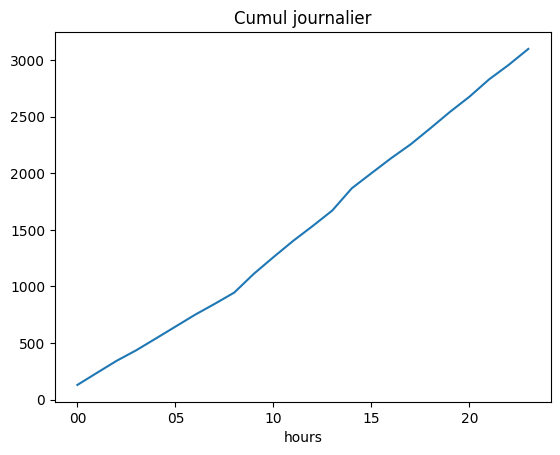

In [102]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

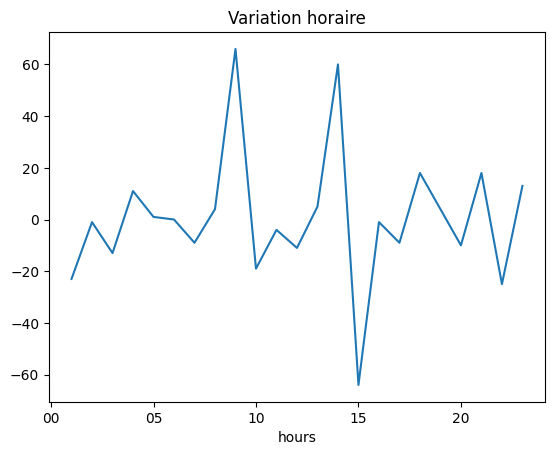

In [103]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [104]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [105]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.765479
min        0.943000
25%        3.124500
50%        3.478000
75%        3.773000
max        4.927000
Name: kWh, dtype: float64

In [106]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '303 days')

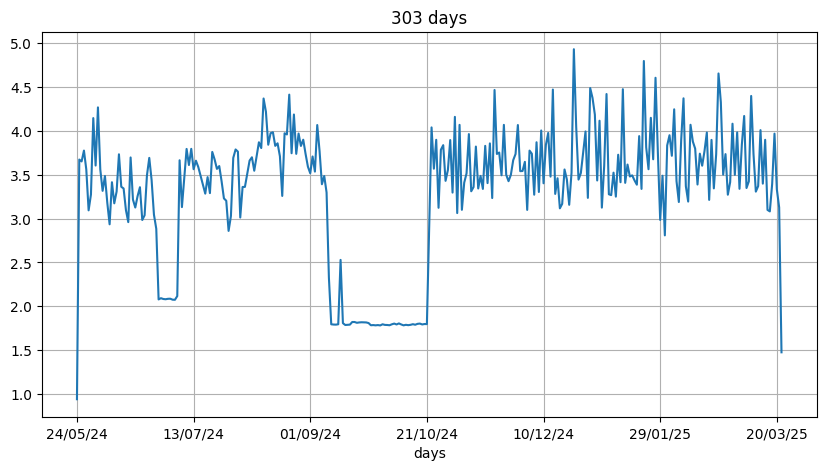

In [107]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

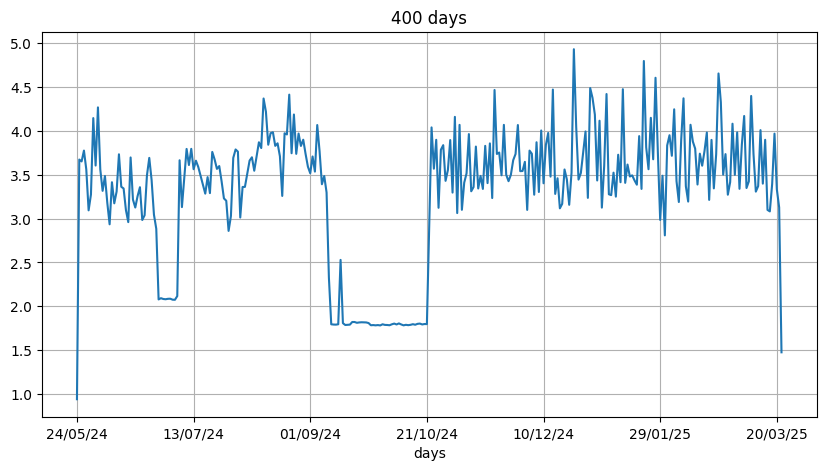

In [108]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [109]:
df_grp['kWh']

days
24/05/24    0.943
25/05/24    3.671
26/05/24    3.650
27/05/24    3.773
28/05/24    3.559
            ...  
18/03/25    3.394
19/03/25    3.966
20/03/25    3.333
21/03/25    3.126
22/03/25    1.477
Name: kWh, Length: 303, dtype: float64

In [110]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.765479
min,0.943000
25%,3.124500
50%,3.478000
75%,3.773000
max,4.927000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

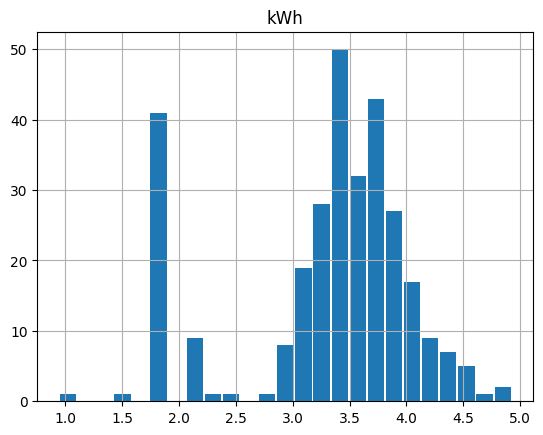

In [111]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [112]:
df_grp.tail(span)['kWh']

days
24/05/24    0.943
25/05/24    3.671
26/05/24    3.650
27/05/24    3.773
28/05/24    3.559
            ...  
18/03/25    3.394
19/03/25    3.966
20/03/25    3.333
21/03/25    3.126
22/03/25    1.477
Name: kWh, Length: 303, dtype: float64

# Conso par heure

In [113]:
day

'22/03/25'

In [114]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,114,114,NaN
01,109,223,-5.0
02,102,325,-7.0
03,104,429,2.0
04,108,537,4.0
05,108,645,0.0
06,550,1195,442.0
07,182,1377,-368.0
08,100,1477,-82.0


In [115]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


9

In [116]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 10)

In [117]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [118]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [119]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [120]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [121]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 00 to 08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     9 non-null      int64  
 1   cumsum  9 non-null      int64  
 2   diff    8 non-null      float64
 3   days    9 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 360.0+ bytes


In [122]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
08    9.0
Name: days, dtype: float64

In [123]:
day

'22/03/25'

In [124]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,114,114,NaN,1.0
01,109,223,-5.0,2.0
02,102,325,-7.0,3.0
03,104,429,2.0,4.0
04,108,537,4.0,5.0
05,108,645,0.0,6.0
06,550,1195,442.0,7.0
07,182,1377,-368.0,8.0
08,100,1477,-82.0,9.0


Text(0.5, 1.0, '22/03/25')

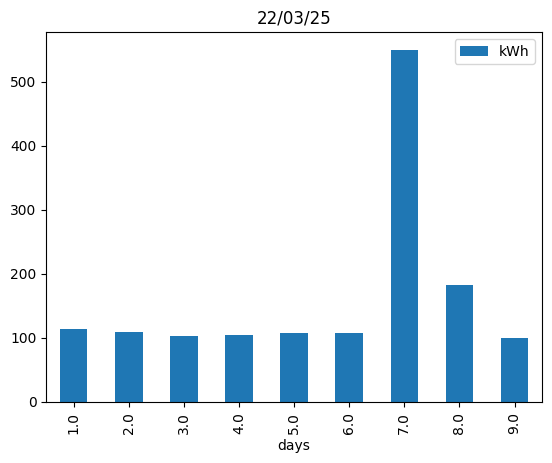

In [125]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [126]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08'], dtype='object', name='hours')

# Conso du jour


In [127]:

grp_by_dayhours.count()

kWh       7237
cumsum    7237
diff      6934
days         9
dtype: int64

In [128]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     135
01     133
02     141
03     110
04     105
05     110
06     108
07     108
08     109
09     110
10     106
11     164
12     143
13     138
14     133
15    1112
16     431
17     136
18     213
19     169
20     243
21     244
22     280
23     246
Name: kWh, dtype: int64

In [129]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
22/03/25  1.477


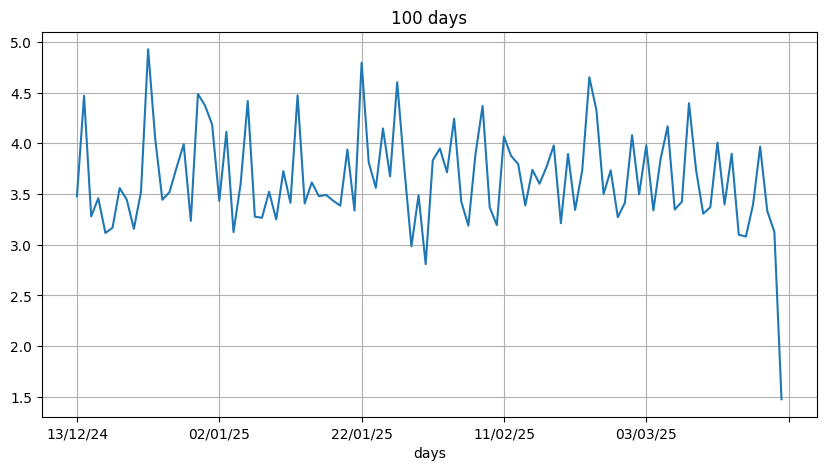

In [130]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [131]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

105.67727327346802


# Today

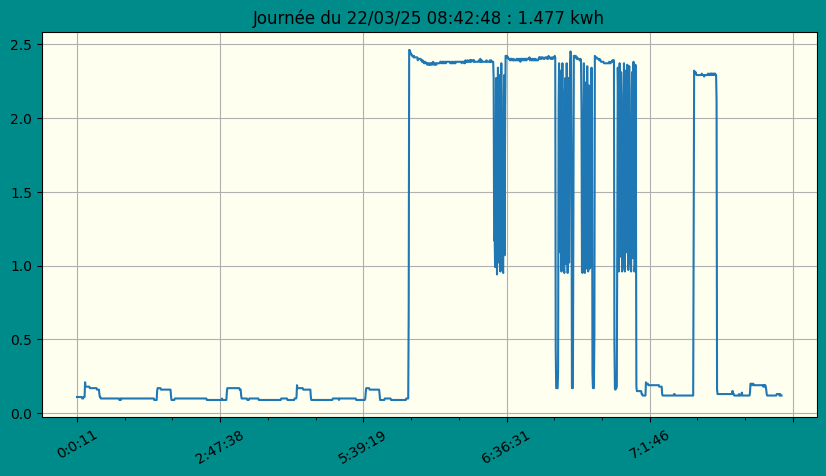

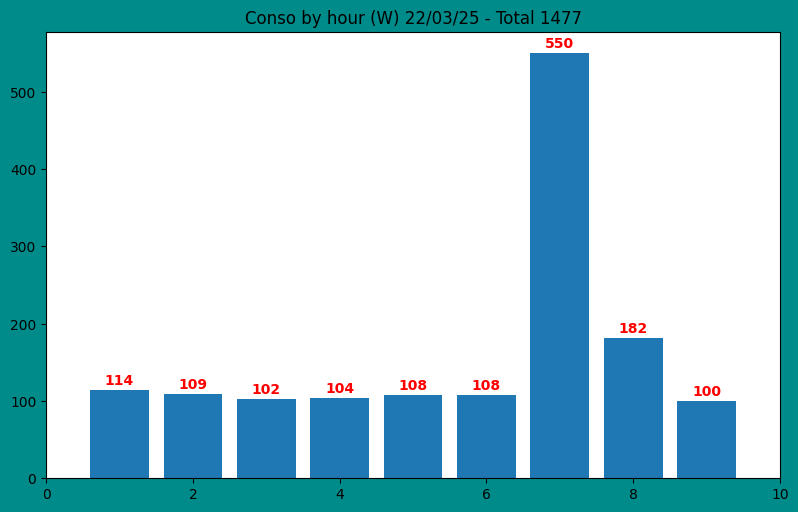

In [132]:
show(today,bgcolor='ivory')
conso_by_hour(today)

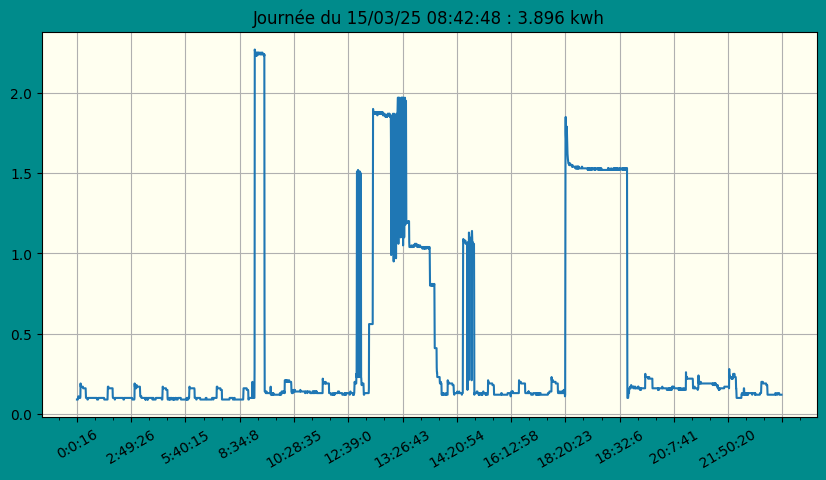

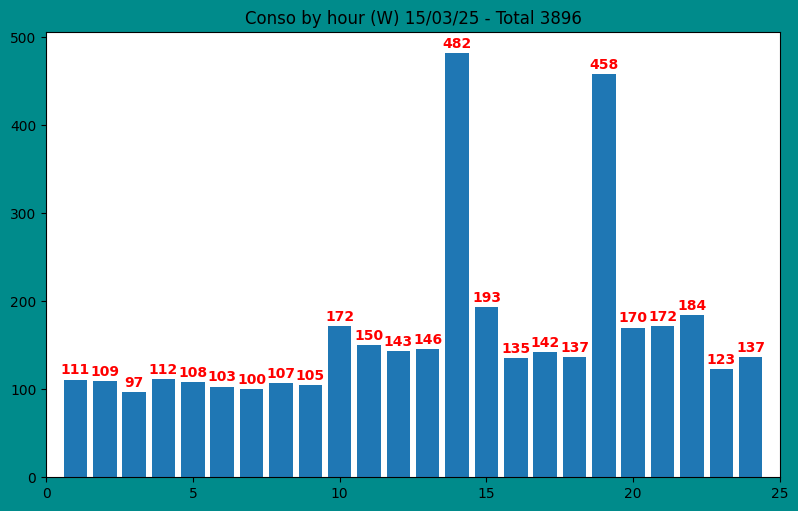

In [133]:
day = '15/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4927)

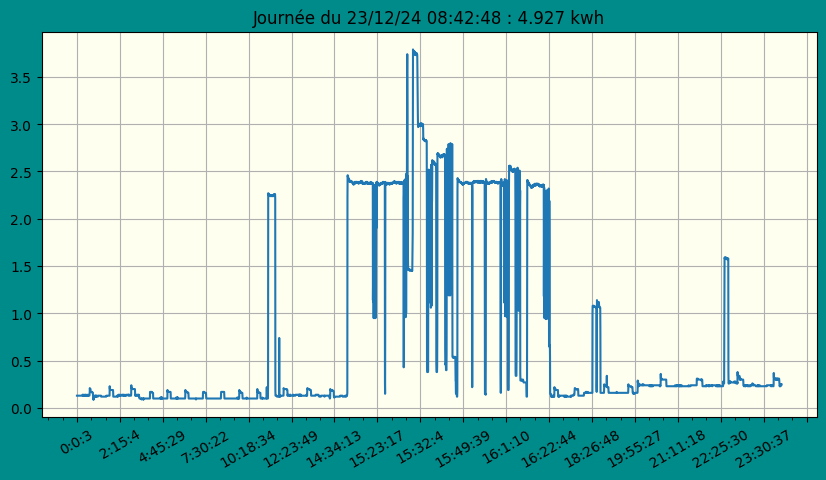

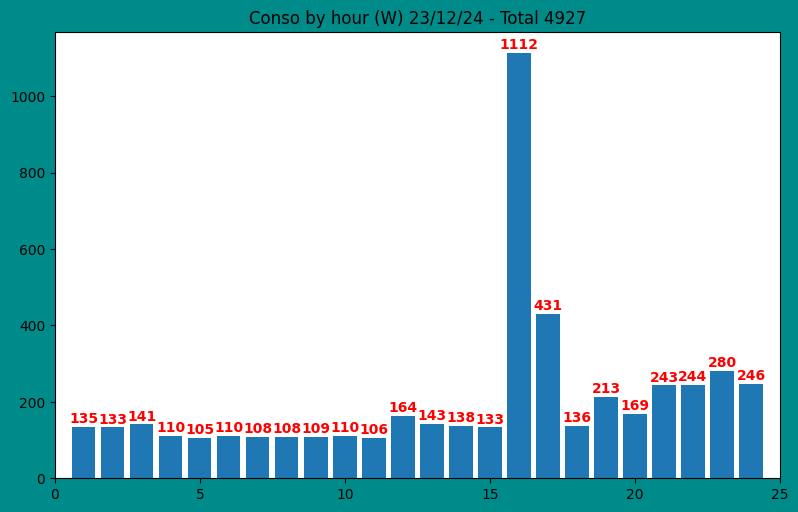

In [134]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

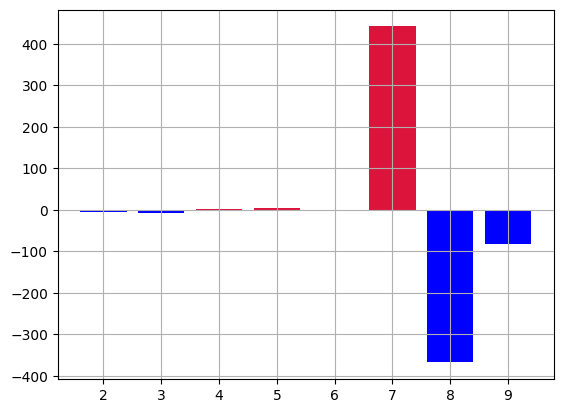

In [135]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

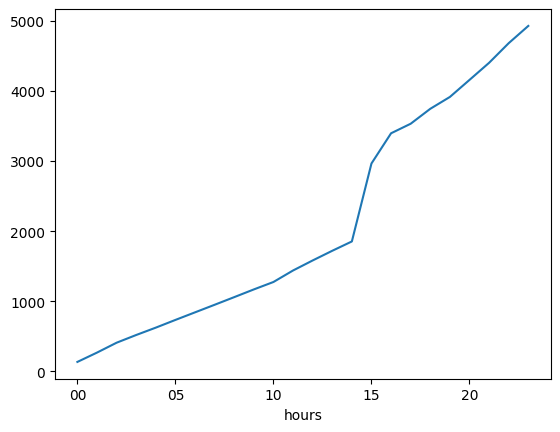

In [136]:
data.cumsum().plot()


<Axes: xlabel='hours'>

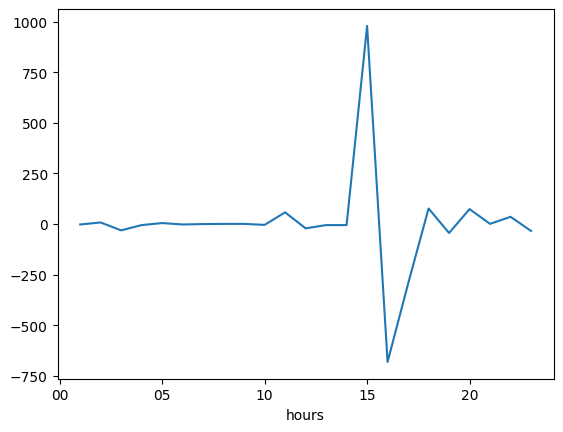

In [137]:
# evolution par heure
data.diff().plot()

In [138]:
data.diff().describe()

count     23.000000
mean       4.826087
std      263.666568
min     -681.000000
25%      -13.000000
50%       -2.000000
75%        6.500000
max      979.000000
Name: kWh, dtype: float64

<Axes: >

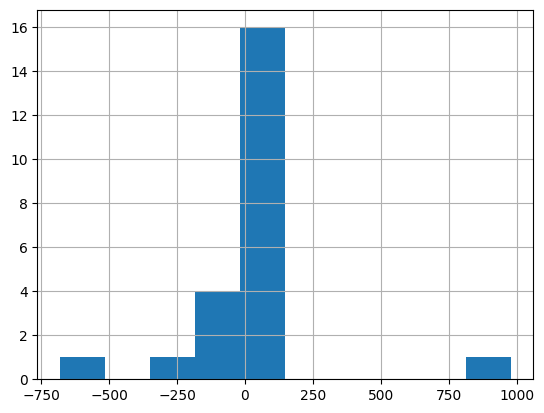

In [139]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [140]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '.vs',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_mini.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptograp

# list store files csv


In [141]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


('23/12/24', None)

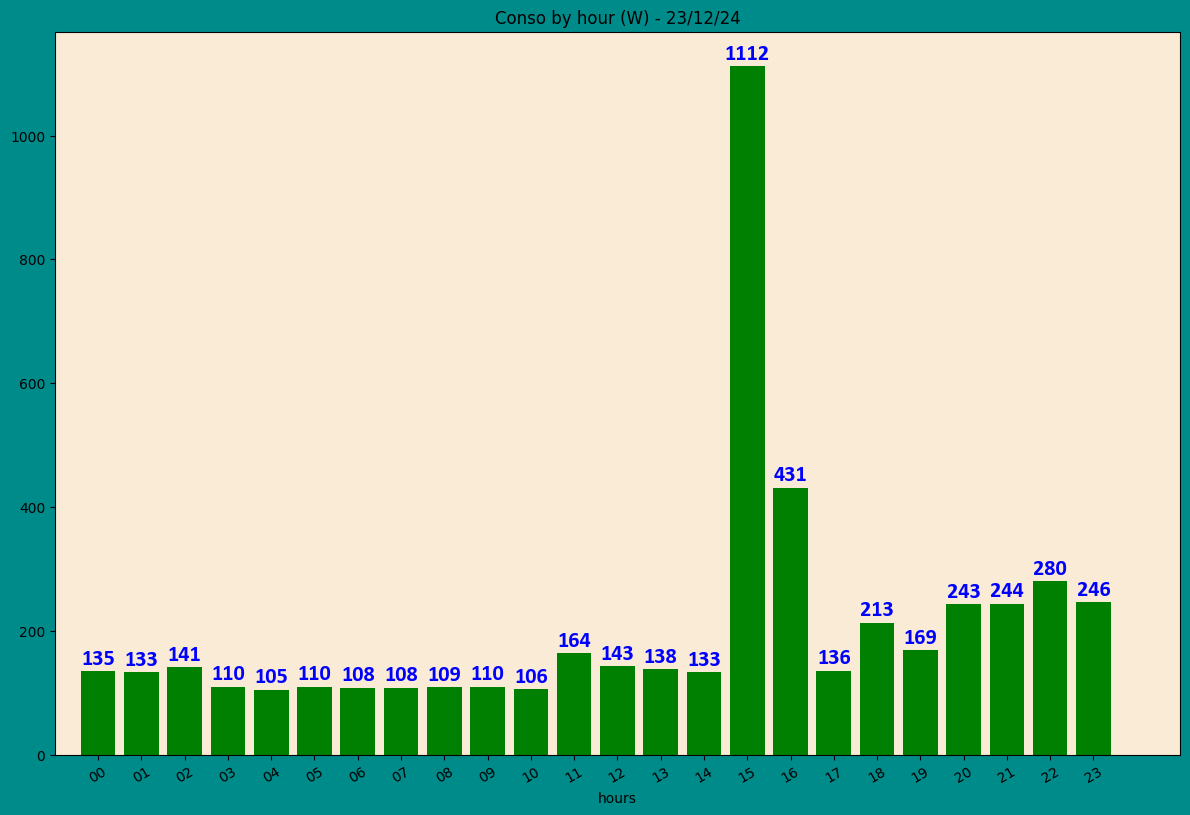

In [142]:
day,conso_byhour(day)

In [143]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


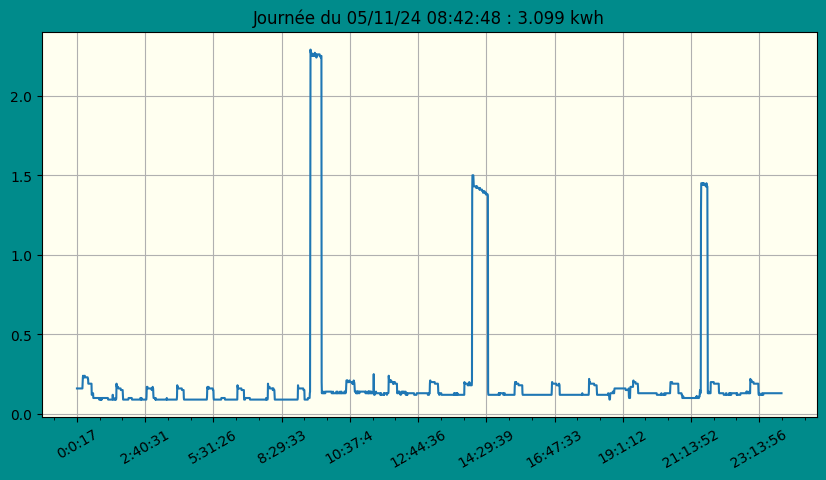

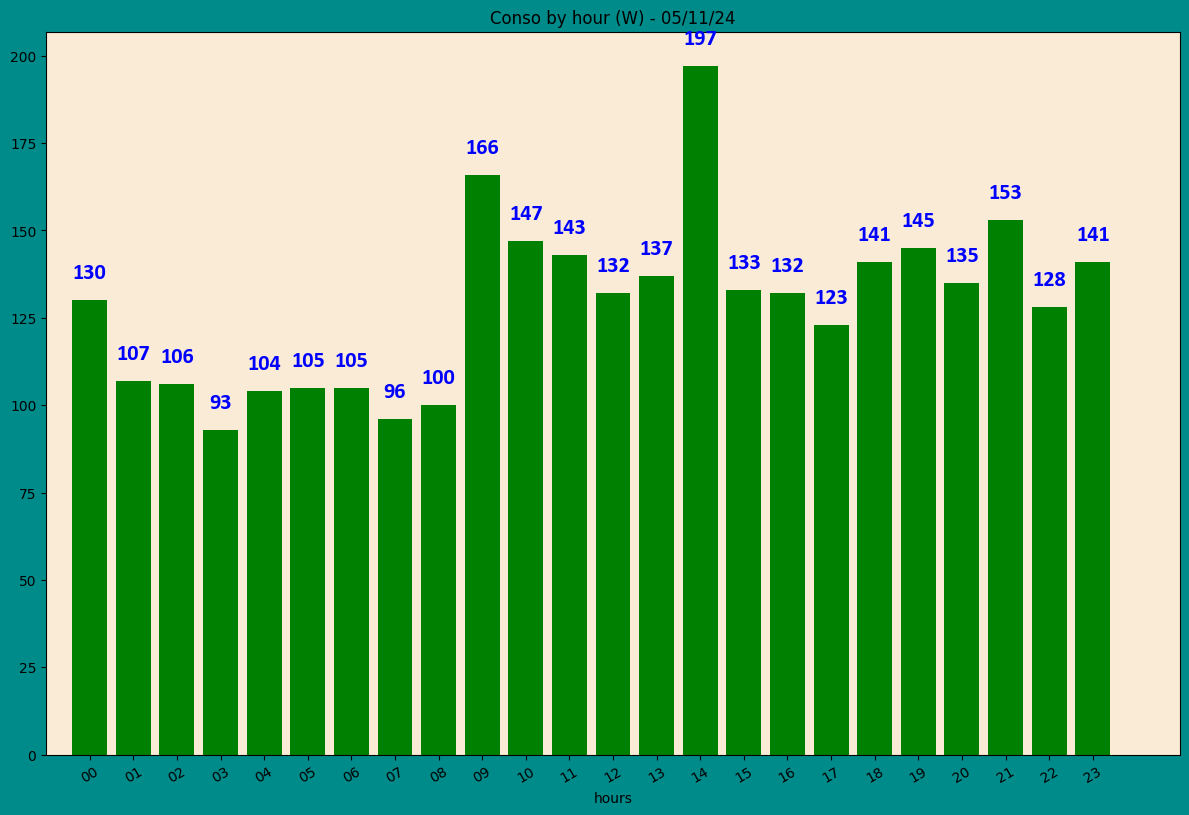

In [144]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [145]:
month

,day,hours,months,kWh
818288,01,00,2025-02,0.23
818289,01,00,2025-02,0.23
818290,01,00,2025-02,0.23
818291,01,00,2025-02,0.23
818292,01,00,2025-02,0.23
...,...,...,...,...
922745,28,23,2025-02,0.17
922746,28,23,2025-02,0.13
922747,28,23,2025-02,0.11
922748,28,23,2025-02,0.11


In [146]:
month.describe()


,kWh
count,104462.000000
mean,0.334576
std,0.555158
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

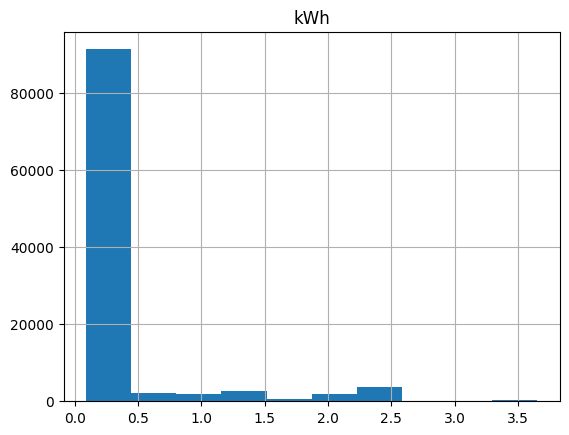

In [147]:
month.hist()

<Axes: >

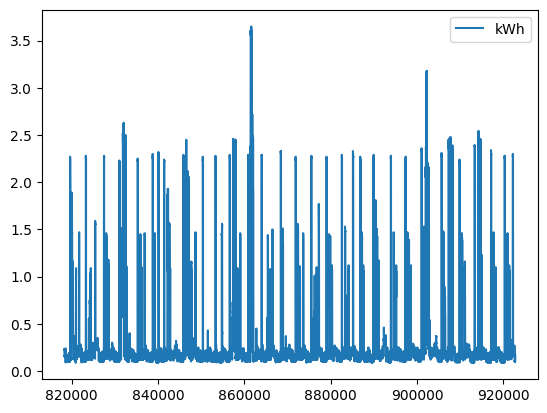

In [148]:
month.plot()

In [149]:
# index with max conso in this month
month.idxmax().kWh

np.int64(861615)

In [150]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       919335
hours     821945
months    818288
kWh       861615
dtype: int64

In [151]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [152]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
24/05/24 20     173     173    NaN   NaN
         21     274     447  101.0   NaN
         22     272     719   -2.0   NaN
         23     224     943  -48.0   NaN
25/05/24 00     229     229    NaN   NaN
...             ...     ...    ...   ...
22/03/25 04     108     537    4.0   5.0
         05     108     645    0.0   6.0
         06     550    1195  442.0   7.0
         07     182    1377 -368.0   8.0
         08     100    1477  -82.0   9.0

[7237 rows x 4 columns]

In [153]:
month

,day,hours,months,kWh
818288,01,00,2025-02,0.23
818289,01,00,2025-02,0.23
818290,01,00,2025-02,0.23
818291,01,00,2025-02,0.23
818292,01,00,2025-02,0.23
...,...,...,...,...
922745,28,23,2025-02,0.17
922746,28,23,2025-02,0.13
922747,28,23,2025-02,0.11
922748,28,23,2025-02,0.11


In [154]:
month.idxmax()


day       919335
hours     821945
months    818288
kWh       861615
dtype: int64

In [155]:
month.loc[month.idxmax().kWh]


day            12
hours          13
months    2025-02
kWh          3.65
Name: 861615, dtype: object

In [156]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       114
          01       112
          02        97
          03       111
          04       112
          05       110
          06        97
          07       110
          08       161
          09       144
          10       134
          11       147
          12       144
          13       200
          14       147
          15       184
          16       162
          17       147
          18       142
          19       168
          20       226
          21       173
          22       154
          23       119
Name: kWh, dtype: int64

In [157]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'20'

<Axes: xlabel='days,hours'>

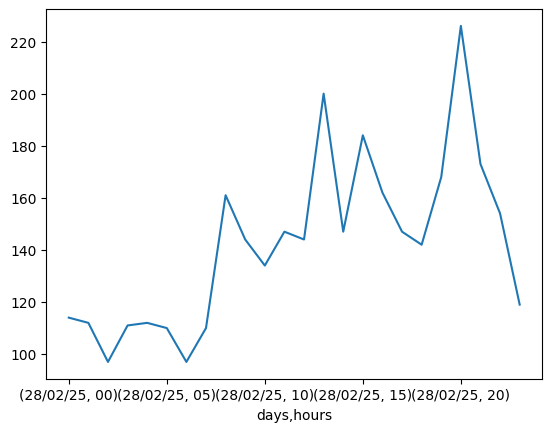

In [158]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [159]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [160]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [161]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [162]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB